In [1]:
#!pip install bert_score

## Comment classification by converting it to a se2seq problem
We are treating as a Label generation problem. The Label will be generated by the decoder. Encoder will encode the comment text. The idea was explored to see if the attention will add any accuracy to the classifications.
The design philosophy is inspired by T5 model where they try to reduce every problem into a seq2seq problem 



In [59]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline
import pandas as pd

In [10]:
##define the maximum length of the comment
MAX_LENGTH = 100

## Create the dataset

We are considering only 11 types of comments since they are only in significant number. 
The data is in the form of comment text|comment classification

These classifications have been done by hand and serve as the initial data set

In [11]:
commentDF = pd.read_csv('data/comments_all.csv')
commentDF=commentDF[['commentText','commentClassification']]
commentDF=commentDF[commentDF['commentClassification'].isin(['BUGGYCODE_SUGGESTION','REFACTORING_SUGGESTION','CODE_SUGGESTION','QUESTIONING',
                    'COMPLETENESS_SUGGESTION','LOGISTICS_SUGGESTION','LOGICAL_SUGGESTION','SPELLING_SUGGESTION',
                     'REUSE_SUGGESTION','DOCUMENTATION_SUGGESTION'])]
#commentDF=commentDF.reset_index()
commentDF.commentClassification.value_counts()
commentDF.shape

(4764, 2)

In [12]:
commentDF

,commentText,commentClassification
0,Please remove it and folder `PaymentsOld` comp...,CODE_SUGGESTION
1,"Are we are not using these strings? then, plea...",REFACTORING_SUGGESTION
2,Call `:paymentId` as `:warehouseId` so that it...,SPELLING_SUGGESTION
3,"No need to make it caps, Button by default sho...",CODE_SUGGESTION
4,Follow `No pending invoices` instead of `No Pe...,SPELLING_SUGGESTION
...,...,...
4855,There is issue in this query with single quote.,BUGGYCODE_SUGGESTION
4856,Needs to be \n` 'ALTER TABLE invoicetemplatem...,CODE_SUGGESTION
4857,Please swap the logic and use isset here. \nw...,BUGGYCODE_SUGGESTION
4858,Please make it re-runable.\n\n‌,BUGGYCODE_SUGGESTION


## utility functions

These functions will be used to clean up the comment text

In [16]:
## function to remove the urls from the comments if any
def removeURLs(text):
    URLless_string=text
    try:
        URLless_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
        #print("removed url")
    except:
        print("some error in removing URL")
    return URLless_string

In [17]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    try:
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s=s.replace('\n','')
        s=s.replace('\r','')
        s=s.replace('\t','')
    except:
        print("issues",s)
    return s

In [18]:
def getDeciles(df,column):
    res=pd.DataFrame(df[column].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])).reset_index()
    res.columns=['quantile','limit']
    return res 

## Apply the preprocessing
The comments will be cleaned up from URLs , any non-ASCII characters, lower cased
After the cleanup the data will be saved in a local file. This file will be used while creating the training & testing strings for the encoder decoder model

In [19]:

commentDF['commentText']=commentDF['commentText'].apply(lambda x:removeURLs(x))
commentDF['commentText']=commentDF['commentText'].apply(normalizeString)
commentDF['commentClassification']=commentDF.commentClassification.apply(normalizeString)
#commentDF

In [20]:
## save the DF to a csv file. This will be used to convert it into the seq2seq form
# trainDF.to_csv("data/commentsPairsTrain.txt",sep="\t",index=False)
# testDF.to_csv("data/commentsPairsTest.txt",sep="\t",index=False)

# commentDF=trainDF
commentDF.to_csv("data/commentsPairs1.txt",sep="\t",index=False)


In [21]:
commentDF

,commentText,commentClassification
0,please remove it and folder paymentsold comple...,code suggestion
1,are we are not using these strings ? then plea...,refactoring suggestion
2,call paymentid as warehouseid so that it s cle...,spelling suggestion
3,no need to make it caps button by default show...,code suggestion
4,follow no pending invoices instead of no pendi...,spelling suggestion
...,...,...
4855,there is issue in this query with single quote .,buggycode suggestion
4856,needs to be alter table invoicetemplatemapping...,code suggestion
4857,please swap the logic and use isset here . wil...,buggycode suggestion
4858,please make it re runable .,buggycode suggestion


In [22]:
### check what is the general length of the comments..this will help in determining 
### if the max length choice is good or bad
## the decile output shows that almost the entire comments are less than 100 characters.
commentDF['stats']=commentDF['commentText'].str.split().apply(len)
getDeciles(commentDF,'stats')

,quantile,limit
0,0.10,3.00
1,0.20,5.00
2,0.30,6.00
3,0.40,8.00
4,0.50,10.00
5,0.60,13.00
6,0.70,16.00
7,0.80,21.00
8,0.90,29.00
9,0.99,69.37


### Dataset preparation code  as per seq2seq model

The problem has been framed as a NMT usecase where given a string of language1 we are trying to get an equivalent transalated string in language2.

We will convert the code to a language transaltion format ..where the comments text is lang1 and the labels is lang2
The task is then to generate the lang2 given the lang1


In [23]:
SOS_token = 0
EOS_token = 1

## the class will store the vocabulary in both word->index and index->word format
## also we have added special SOS and EOS characters to mark the start and end of the sentences
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [24]:
## the function will create teh vocabulary for both the comments and the labels.. Also it will create the pairs
def readLangs(lang1, lang2, fileName, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(fileName, encoding='utf-8').\
        read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances for each part of the pair
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [25]:
## this will make sure that we have only MAX_LENGHT string
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [26]:
def prepareData(lang1, lang2,fileName, reverse=False):
    #get the pairs and the two langugae instances
    input_lang, output_lang, pairs = readLangs(lang1, lang2,fileName, reverse)
    
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    ## for each of the pairs we need to add it as a sentence and hence the tokens to the vocabulary
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [27]:
def indexesFromSentence(lang, sentence):
    listWords=[]
    for word in sentence.split(' '):
        try:
            listWords.append(lang.word2index[word])
        except:
            print("cc--",word)
    return listWords


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [29]:
input_lang, output_lang, pairs = prepareData('comment', 'label','data/commentsPairs1.txt', False)
print(random.choice(pairs))

Reading lines...
Read 4765 sentence pairs
Trimmed to 4752 sentence pairs
Counting words...
Counted words:
comment 4396
label 14
['space after please use space after and before', 'refactoring suggestion']


In [30]:
## check the labels
input_lang.word2index
   

{'commenttext': 2,
 'please': 3,
 'remove': 4,
 'it': 5,
 'and': 6,
 'folder': 7,
 'paymentsold': 8,
 'completely': 9,
 '.': 10,
 'we': 11,
 'can': 12,
 'create': 13,
 'mock': 14,
 'in': 15,
 'all': 16,
 'new': 17,
 'apis': 18,
 'payments': 19,
 'itself': 20,
 'are': 21,
 'not': 22,
 'using': 23,
 'these': 24,
 'strings': 25,
 '?': 26,
 'then': 27,
 'removed': 28,
 'changes': 29,
 'call': 30,
 'paymentid': 31,
 'as': 32,
 'warehouseid': 33,
 'so': 34,
 'that': 35,
 's': 36,
 'clear': 37,
 'showing': 38,
 'payment': 39,
 'warehouse': 40,
 'wise': 41,
 'no': 42,
 'need': 43,
 'to': 44,
 'make': 45,
 'caps': 46,
 'button': 47,
 'by': 48,
 'default': 49,
 'shows': 50,
 'spaces': 51,
 'export': 52,
 'const': 53,
 'proceed': 54,
 'pay': 55,
 'trans': 56,
 'follow': 57,
 'pending': 58,
 'invoices': 59,
 'instead': 60,
 'of': 61,
 'i': 62,
 'have': 63,
 'tried': 64,
 'for': 65,
 'flow': 66,
 'this': 67,
 'most': 68,
 'the': 69,
 'places': 70,
 'key': 71,
 'nav': 72,
 'links': 73,
 'thinks': 74

In [4]:
#commentDF['commentClassification'].value_counts()*.20

## Splitting the data into test and training set
1. Basically we first created the vocabulary
2. Then we are using the train_test cplit to create the training and test DF
3. finally the df are converted to the pairs as it is required in the seq2seq network
4. removed the comments which are greater than MAX_LEN

In [31]:
from sklearn.model_selection import train_test_split

# save features and targets from the 'iris'
features, targets = commentDF.commentText.values, commentDF.commentClassification.values

# both train_size and test_size are defined when we do not want to
# use all the data for training and testing e.g. in below example we can
# use train_size=0.4 and test_size=0.2
train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=23,
        # keep same proportion of 'target' in test and target data
        stratify=targets
    )

In [32]:
trainDF=pd.DataFrame()
trainDF['commentText']=list(train_features)
trainDF['commentClassification']=list(train_targets)
trainDF['length'] = trainDF.commentText.str.len()
trainDF=trainDF[trainDF['length']<MAX_LENGTH]
trainDF.to_csv('attentionTrain.csv')

In [33]:
testDF=pd.DataFrame()
testDF['commentText']=list(test_features)
testDF['commentClassification']=list(test_targets)
testDF['length'] = testDF.commentText.str.len()
testDF=testDF[testDF['length']<MAX_LENGTH]
testDF.to_csv('attentionTest.csv')
testDF['commentClassification'].value_counts()

refactoring suggestion      168
buggycode suggestion        136
code suggestion             124
questioning                  91
completeness suggestion      67
logistics suggestion         65
spelling suggestion          33
logical suggestion           31
reuse suggestion              9
documentation suggestion      6
Name: commentClassification, dtype: int64

In [34]:
## make sure that we are removing all the comments that are larger than the MAX length
testPairs=[]
for i in range(testDF.shape[0]):
    if(len(testDF.iloc[i]['commentText'].split(' ')) < MAX_LENGTH):
        testPairs.append([testDF.iloc[i]['commentText'],testDF.iloc[i]['commentClassification']])
    
#testPairs

trainPairs=[]
for i in range(trainDF.shape[0]):
    if(len(trainDF.iloc[i]['commentText'].split(' ')) < MAX_LENGTH):
        trainPairs.append([trainDF.iloc[i]['commentText'],trainDF.iloc[i]['commentClassification']])
    

## Encoder Class
It follows are basic architecture of Input Tensor >> Emebedding Layer >> GRU

Refer to the diagram 
![image](img/encoder.png)


In [35]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Mechanism

There are two classes defined to compute the attention scores in two ways:

1. Additive Attention : The attention is calculated using the Bahdanau method https://arxiv.org/abs/1409.0473

essentially it means that the attention score is calculated as 
$e_i=V^T * tanh(W_1h_i+W_2s_t)$ where $h_i$ are the encoder states and s is the decoder state at time t. $W_1, W_2, V$ are the weight matrices to combine the encoder states and the decoder state. They are the learning paramters


2. Multiplicative Attention : this attention is calculatied using the method described by Luong https://arxiv.org/abs/1508.04025

In this case the attention score is calculated as $e_i=s^TWh_i$ , where W is the weight matrix that is used to combine the encoder states $h_i$ with the decoder state s



Following are the steps that need to be followed to use the attention in the seq2seq 

1. Calculate the attention scores $e^t$ .. these will vary for each of the decoder state $s_t$
2. Normalize the attention score by taking softmax to get $\alpha^t$ basically $softmax(e^t) \rightarrow [\alpha_1,\alpha_2...\alpha_N]$
3. Now get the relative importance of the encoder state by multiplying the attention score with the encoder state and this is the attention weight
$a^t=\alpha_1h_1 + \alpha_2h_2 + \alpha_Nh_N => \sum_{i=1}^{N}\alpha_ih_i $  

4. Finaly we need to combine the attention with the input to the decoder state. This is required as GRU can take only 1 input. 
earlier gru input was $O_t\__1$  and hidded state was $s_t\__1$ now it will be changed to $concat(O_t\__1,a^t)$ and 
$s_t\__1$


![image](img/attentionInput.png)


In [36]:
class AdditiveAttention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim):
        super(AdditiveAttention,self).__init__()
        self.decoder_dim=decoder_dim #256 this is the dimention of the D(t-1)
        self.encoder_dim=encoder_dim ## the diemtion of each outut of the encoder...this in our case is 256 
        self.W_Combined = torch.nn.Parameter(
            torch.FloatTensor(self.decoder_dim).uniform_(-0.1, 0.1)) ## this is one of the weight matrix that will be sed to combine the weitghs
        
        self.W_Decoder = torch.nn.Linear(decoder_dim, decoder_dim)# adding weight to the decoder
        self.W_EncoderOutput = torch.nn.Linear(encoder_dim, decoder_dim) ## this will convert the encoder to decoeer dimention

    def get_weights(self,        
        query: torch.Tensor,  # query = decoder hidden
        values: torch.Tensor,  # encoder output of the form maxLength*encoder_dim in ou r case it is 10x256
    ):
#         query = query.repeat(values.size(0), 1)  # [seq_length, decoder_dim]..we need to add the query to each value of encoder
        ##query is 1x256 and ecoder is 10x 256 to add there will be implicit broadcasting
        attn_weights = self.W_Decoder(query) + self.W_EncoderOutput(values)  # [seq_length, decoder_dim]
        return F.softmax((torch.tanh(attn_weights) @ self.W_Combined),dim=1) # [seq_length]

In [37]:
import numpy as np
class MultiplicativeAttention(nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super(MultiplicativeAttention,self).__init__()
        self.decoder_dim=decoder_dim
        self.encoder_dim=encoder_dim
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return F.softmax((weights/np.sqrt(self.decoder_dim)),dim=1)  # [seq_length]

## Decoder making use of the Attention

In [38]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       
        ## making use of the multiplicative attention
        self.attention = MultiplicativeAttention(256,256)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights=self.attention.get_weights(hidden[0],encoder_outputs)

        
        ##all this is generic
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


## Training Logic
we are making use of the Teacher Forcing which is a way of sending the actual ground truth while the trainign is going on

In [39]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    ##encode the input
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    ##initialize decoder and proceed
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #print("train:",decoder_output,target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            ##Gru will take 1 input and gives out the output probabilities. Topk or 
            ## the beam is basically to take the top k probability words based on the decoder lstm output
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### utility function for capturing the time of  execution

In [44]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## METRICS


Function to calculate the **BERT Score**. We are using the bert_score library to do so
The function will take as input the encoder and decoder objects and generate the F1 score on the basis of the Precision and Recall

The BERTScore is essentially doing the validation of the model that has been trained so far. That is why it is calling the evaluate() ...we will be using the testPairs which is the data that the model has not seen till now

In [45]:
## bleu score metrics
from bert_score import score

def getDataForBertScore(encoder,decoder):
    candidates=[]
    references=[]
    for i in range(len(testPairs)):
        pair = testPairs[i]
        references.append(pair[1])
        #print(pair)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        output_sentence=output_sentence.replace('<EOS>','')#candidate
        candidates.append(output_sentence)
    #referencesFinal=[[i] for i in references]
    P, R, F1 = score(candidates, references, lang="en", verbose=False)
    return F1.mean()

Function to calculate the **BLEU score**. We are using the pytorch implementation of the BLEU score
The function will take as input the encoder and decoder objects and generate the BLEU score We are using the maximum n-gram=2 which means we will consider unigram, bigram to calculate the score The weightage of all of them is 0.5

The BLEUScore is essentially doing the validation of the model that has been trained so far. That is why it is calling the evaluate() ...we will be using the testPairs which is the data that the model has not seen till now

In [46]:
from torchtext.data.metrics import bleu_score
def getBlueScore(encoder,decoder):
    candidates=[]
    references=[]
    for i in range(len(testPairs)):
        pair = testPairs[i]
        #print(pair)
        #print('>', pair[0])#input
        #print('=', pair[1])#groundtruth
        tmp=list(pair[1].split())
        #tmp2=list(tmp)
        references.append(tmp)
        #print(pair)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        output_sentence=output_sentence.replace('<EOS>','')#candidate

        candidates.append(list(output_sentence.split()))
    referencesFinal=[[i] for i in references]
    
    score=bleu_score(candidates, referencesFinal,max_n=2,weights=[0.5,0.5])
    return score

## training iterator
In case of the se2se model the training is done by passing pairs containign the input and output
For each pair we will check the loss. 

![image](img/trainingloop.png)



In [47]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    metrics=[]
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
                
            ## adding the BLEU Score
            blue_score=getBlueScore(encoder,decoder)
            #blue_score=0
            ## Perplexity
            perplexity=math.exp(print_loss_avg)
            ##BERTScore
            bert_score=getDataForBertScore(encoder,decoder)
            #bert_score=0
            print('%s | (%d %d%%) | AVG_LOSS = %.4f|  BLEU= %.4f | PPL=%7.3f | BERTSCORE=%.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg,blue_score,perplexity,bert_score))
            
            metrics.append({"iter":iter,"AVG_LOSS":print_loss_avg,"BLEU":blue_score,"PPL":perplexity,"BERTSCORE":bert_score})
           
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            

    return plot_losses,metrics

In [48]:
## function is called by the BLEU and the BErtScore to calcualte the validation error
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]




### function to evaluate the accuracy on random sample and on all the test data

In [49]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(testPairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        
def evaluateAll(encoder, decoder):
    pred=[]
    true_val=[]
    for i in range(len(testPairs)):
        pair = testPairs[i]
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        output_sentence=output_sentence.replace('<EOS>','')
        output_sentence=output_sentence.strip()
        print('<', output_sentence)
        pred.append(output_sentence)
        true_val.append(pair[1])
        print('')
        
    fff=pd.DataFrame(pred)
    fff['true_label']=true_val
    fff.columns=['pred_label','true_label']
    fff['diff']=0
    fff.loc[(fff['pred_label']!=fff['true_label']),'diff']=1
    return pred,true_val,fff


### the actual training starts here with 75000 epochs
Basically we are sampling the training data to get 750000 pairs (data augmentaion)

In [50]:
import logging
logging.basicConfig(level=logging.ERROR)

hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses1,metrics1=trainIters(encoder2, attn_decoder2, 75000, print_every=5000)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0m 57s (- 13m 21s) | (5000 6%) | AVG_LOSS = 0.6568|  BLEU= 0.6917 | PPL=  1.929 | BERTSCORE=0.9664


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1m 51s (- 12m 3s) | (10000 13%) | AVG_LOSS = 0.4584|  BLEU= 0.7759 | PPL=  1.581 | BERTSCORE=0.9759


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2m 45s (- 11m 1s) | (15000 20%) | AVG_LOSS = 0.3347|  BLEU= 0.8376 | PPL=  1.398 | BERTSCORE=0.9823


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3m 39s (- 10m 4s) | (20000 26%) | AVG_LOSS = 0.2350|  BLEU= 0.8802 | PPL=  1.265 | BERTSCORE=0.9864


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


4m 34s (- 9m 8s) | (25000 33%) | AVG_LOSS = 0.1634|  BLEU= 0.9133 | PPL=  1.178 | BERTSCORE=0.9908


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5m 28s (- 8m 12s) | (30000 40%) | AVG_LOSS = 0.1163|  BLEU= 0.9463 | PPL=  1.123 | BERTSCORE=0.9937


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


6m 22s (- 7m 16s) | (35000 46%) | AVG_LOSS = 0.0753|  BLEU= 0.9649 | PPL=  1.078 | BERTSCORE=0.9962


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7m 16s (- 6m 22s) | (40000 53%) | AVG_LOSS = 0.0471|  BLEU= 0.9754 | PPL=  1.048 | BERTSCORE=0.9975


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


8m 11s (- 5m 27s) | (45000 60%) | AVG_LOSS = 0.0227|  BLEU= 0.9759 | PPL=  1.023 | BERTSCORE=0.9974


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


9m 6s (- 4m 33s) | (50000 66%) | AVG_LOSS = 0.0193|  BLEU= 0.9908 | PPL=  1.019 | BERTSCORE=0.9990


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


10m 1s (- 3m 38s) | (55000 73%) | AVG_LOSS = 0.0160|  BLEU= 0.9847 | PPL=  1.016 | BERTSCORE=0.9985


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


10m 56s (- 2m 44s) | (60000 80%) | AVG_LOSS = 0.0117|  BLEU= 0.9885 | PPL=  1.012 | BERTSCORE=0.9989


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11m 51s (- 1m 49s) | (65000 86%) | AVG_LOSS = 0.0042|  BLEU= 0.9897 | PPL=  1.004 | BERTSCORE=0.9990


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


12m 46s (- 0m 54s) | (70000 93%) | AVG_LOSS = 0.0027|  BLEU= 0.9874 | PPL=  1.003 | BERTSCORE=0.9987


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


13m 40s (- 0m 0s) | (75000 100%) | AVG_LOSS = 0.0025|  BLEU= 0.9874 | PPL=  1.002 | BERTSCORE=0.9987


In [51]:
## save the results to the path
torch.save(encoder2,'modelFiles/encoder_qa_comments.pth')
torch.save(attn_decoder2,'modelFiles/decoder_qa_comments.pth')
torch.save(input_lang,'modelFiles/inputLang.pkl')
torch.save(output_lang,'modelFiles/outputLang.pkl')


In [52]:
## check how many sample were misclassified by the model on the test data
pred,trueVal,fff=evaluateAll(encoder2, attn_decoder2)

> please get it verified will merge once verified .
= completeness suggestion
< completeness suggestion

> add support for join with roles table
= code suggestion
< code suggestion

> please give us the query so that we can analyze .
= completeness suggestion
< completeness suggestion

> camelcase
= spelling suggestion
< spelling suggestion

> why proper description of changes missing ?
= documentation suggestion
< documentation suggestion

> hardcoded to true ? if this is just a stub please add some comments and todo to tag it for later .
= buggycode suggestion
< buggycode suggestion

> kindly note we also have addition from controller .
= logical suggestion
< logical suggestion

> please rename this file
= spelling suggestion
< spelling suggestion

> please resolve the conflicts . .
= logistics suggestion
< logistics suggestion

> correct indentation to single tabs . dual tabs used here .
= refactoring suggestion
< refactoring suggestion

> on hold as discussed with vidya .
= logisti

< refactoring suggestion

>  b be b a ce a fd please check an the same and update .
= completeness suggestion
< completeness suggestion

> this is not addressed . ffc ed dbf da ae 
= buggycode suggestion
< logistics suggestion

>  e a b fe a c ad c please have a look that image should fix into the row properly .
= buggycode suggestion
< buggycode suggestion

> remove this logs
= refactoring suggestion
< refactoring suggestion

> as per the crash log here the intent object is null . please recheck once .
= completeness suggestion
< completeness suggestion

> please make a procative of adding space after and before . please add space before and after 
= refactoring suggestion
< refactoring suggestion

> is this available for all companies ?
= questioning
< questioning

> please use constants for these numbers instead of magic numbers writing in code .
= buggycode suggestion
< buggycode suggestion

> doing update on this pr .
= logistics suggestion
< logistics suggestion

> this looks to 

< refactoring suggestion

> remove the space
= refactoring suggestion
< refactoring suggestion

> i think there should be a key on phone number
= logical suggestion
< logical suggestion

> import usestate directly instead of react .usestate 
= code suggestion
< code suggestion

>  b c a beeaebbdf will this key will be available in old company ?
= questioning
< questioning

> remove commented code .
= refactoring suggestion
< refactoring suggestion

>  f e f f a a f if there is time please write the test cases . otherwise looks good to me
= completeness suggestion
< completeness suggestion

> remove commented styles
= refactoring suggestion
< refactoring suggestion

> if it s empty can be removed right ? please check .
= refactoring suggestion
< refactoring suggestion

> use a constant for this value
= buggycode suggestion
< buggycode suggestion

>  ab a a fcf f please use proper indentation and format all the files .
= refactoring suggestion
< refactoring suggestion

> please check the

< completeness suggestion

>  a e a f b e d d ed e there are lot of commented code in this file please look into those .
= refactoring suggestion
< refactoring suggestion

>  onclick handleclick 
= code suggestion
< logistics suggestion

> its qa verified please check and resolve conflict 
= logistics suggestion
< logistics suggestion

> empty line can be removed .
= refactoring suggestion
< refactoring suggestion

> i looks like a duplicate file of recentorders .js please remove if it s not required .
= refactoring suggestion
< refactoring suggestion

> please rename this you are not sending the outlet list you are building it
= spelling suggestion
< spelling suggestion

> please correct the spelling credit 
= spelling suggestion
< spelling suggestion

>  .filter boolean or some such variant can do the same
= code suggestion
< code suggestion

> condition not required
= buggycode suggestion
< buggycode suggestion

>  f ea d fb a f c why can t we re use or modify this one ?
= questioni

< logistics suggestion

>  const downloadfile filename . . . 
= code suggestion
< code suggestion

> please remove exit
= refactoring suggestion
< refactoring suggestion

>  ffc ed dbf da ae please rename this file as ledgers .jsx 
= spelling suggestion
< spelling suggestion

> can we define the type here instead of keeping it raw ?
= code suggestion
< code suggestion

> index userhqindex user id headquarter id add this in create table command 
= code suggestion
< code suggestion

> please use brackets for single if line .
= refactoring suggestion
< refactoring suggestion

> space after 
= refactoring suggestion
< refactoring suggestion

> please get it verified we can merge once verified .
= completeness suggestion
< completeness suggestion

> correct indentation
= refactoring suggestion
< refactoring suggestion

> you are not passing cell config here ?
= questioning
< questioning

> done bhai merging it .
= logistics suggestion
< logistics suggestion

> unnecessary changes !
= buggyc

In [53]:
sum(fff['diff'])

11

In [54]:
##check the results with random sampel
evaluateRandomly(encoder2, attn_decoder2)


> why ? here
= questioning
< questioning <EOS>

> use space after comma use space before and after 
= refactoring suggestion
< refactoring suggestion <EOS>

> use owr standard formate of sending broadcast use constansts variables 
= code suggestion
< code suggestion <EOS>

> resolve conflict
= logistics suggestion
< logistics suggestion <EOS>

>  verified
= logistics suggestion
< logistics suggestion <EOS>

> link this model in user .php and use the link instead of loadmodel .
= code suggestion
< code suggestion <EOS>

> don t use my in any kind of variable names please correct it .
= spelling suggestion
< spelling suggestion <EOS>

> please get it verified and update the pr once verified .
= completeness suggestion
< completeness suggestion <EOS>

> please use constants for these numbers instead of magic numbers writing in code .
= buggycode suggestion
< buggycode suggestion <EOS>

> check for response ! null also
= code suggestion
< code suggestion <EOS>



## Show Graphs

In [55]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    

<Figure size 864x432 with 0 Axes>

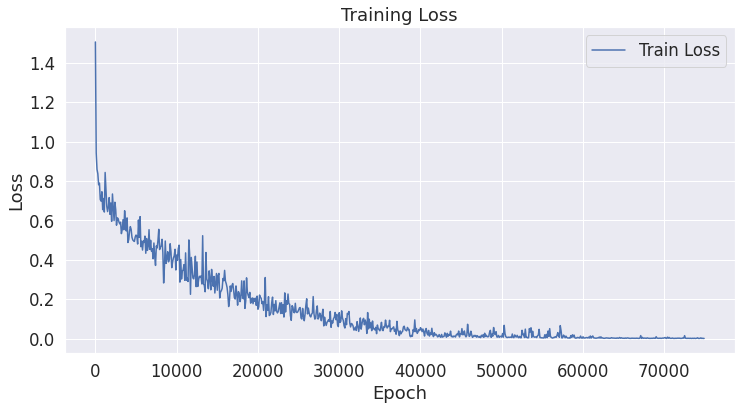

In [60]:
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
plt.plot(plot_losses1,label='Train Loss')

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

ax.yaxis.set_major_locator(loc)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: (int(x))*100))
#plt.plot(plot_losses1,label='Train Loss')


In [61]:
df_stats=pd.DataFrame(metrics1)
df_stats['BERTSCORE']=df_stats['BERTSCORE'].apply(lambda x: x.detach().numpy())
df_stats.rename(columns = {'iter':'epoch'}, inplace = True)
df_stats

,epoch,AVG_LOSS,BLEU,PPL,BERTSCORE
0,5000,0.656842,0.691733,1.928691,0.966384
1,10000,0.458370,0.775883,1.581494,0.975909
2,15000,0.334709,0.837557,1.397534,0.982253
3,20000,0.234967,0.880250,1.264867,0.986371
4,25000,0.163426,0.913293,1.177538,0.990803
5,30000,0.116327,0.946304,1.123364,0.993740
6,35000,0.075260,0.964850,1.078165,0.996155
7,40000,0.047092,0.975353,1.048218,0.997480
8,45000,0.022682,0.975859,1.022941,0.997446
9,50000,0.019273,0.990813,1.019460,0.999044


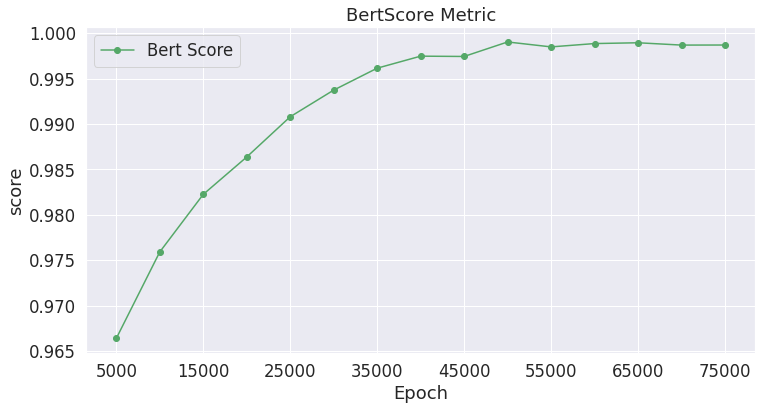

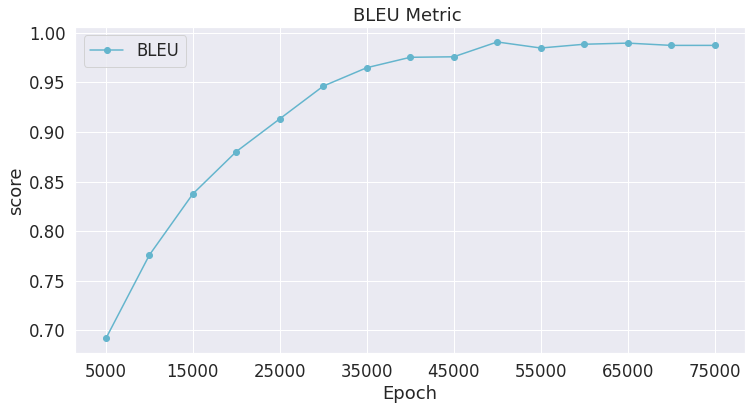

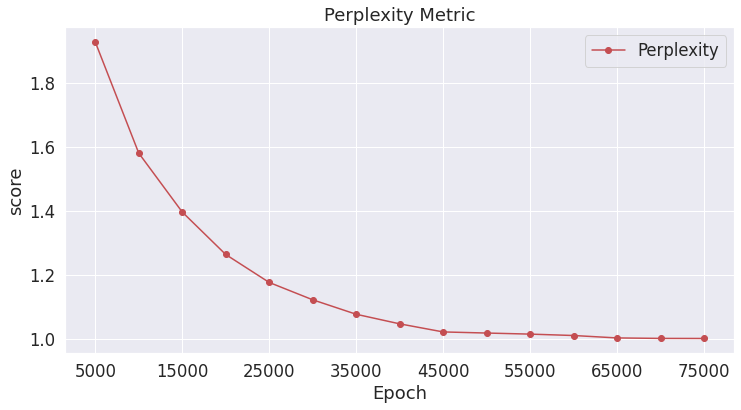

In [62]:
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
titleAxisArr=['BertScore Metric','BLEU Metric ','Perplexity Metric']
labelsArr=['Bert Score','BLEU','Perplexity']
colorArr=['g-o','c-o','r-o']
plotTypeVar=['BERTSCORE','BLEU','PPL']
for i in range(len(plotTypeVar)):

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')
    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    # Plot the learning curve.
    #plt.plot(df_stats['AVG_LOSS'], 'b-o', label="Train Loss")
    #plt.plot(df_stats['BLEU'], 'g-o', label="BLEU")
    #plt.plot(df_stats['PPL'], 'r-o', label="Perplexity")
    #plt.plot(df_stats['BERTSCORE'], 'c-o', label="Bert Score")
    plt.plot(df_stats[plotTypeVar[i]], colorArr[i], label=labelsArr[i])


    # Label the plot.
    plt.title(titleAxisArr[i])
    plt.xlabel("Epoch")
    plt.ylabel("score")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: (int(x)+1)*5000))
    plt.show()